# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)


# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [125]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt


## Imports

Run the imports block below:

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au, \
    DeepRacerLog, \
    S3FileHandler

import os

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
print("ok")

ok


## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [127]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [128]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

2022_april_open.npy
2022_april_open_ccw.npy
2022_april_open_cw.npy
2022_april_pro.npy
2022_april_pro_ccw.npy
2022_april_pro_cw.npy
2022_august_open.npy
2022_august_open_ccw.npy
2022_august_open_cw.npy
2022_august_pro.npy
2022_august_pro_ccw.npy
2022_august_pro_cw.npy
2022_july_open.npy
2022_july_pro.npy
2022_july_pro_ccw.npy
2022_july_pro_cw.npy
2022_june_open.npy
2022_june_open_ccw.npy
2022_june_open_cw.npy
2022_june_pro.npy
2022_june_pro_ccw.npy
2022_june_pro_cw.npy
2022_march_open.npy
2022_march_open_ccw.npy
2022_march_open_cw.npy
2022_march_pro.npy
2022_march_pro_ccw.npy
2022_march_pro_cw.npy
2022_may_open.npy
2022_may_open_ccw.npy
2022_may_open_cw.npy
2022_may_pro.npy
2022_may_pro_ccw.npy
2022_may_pro_cw.npy
2022_october_open.npy
2022_october_open_ccw.npy
2022_october_open_cw.npy
2022_october_pro.npy
2022_october_pro_ccw.npy
2022_october_pro_cw.npy
2022_reinvent_champ.npy
2022_september_open.npy
2022_september_open_ccw.npy
2022_september_open_cw.npy
2022_september_pro.npy
2022_sep

Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 119 waypoints


<Axes: >

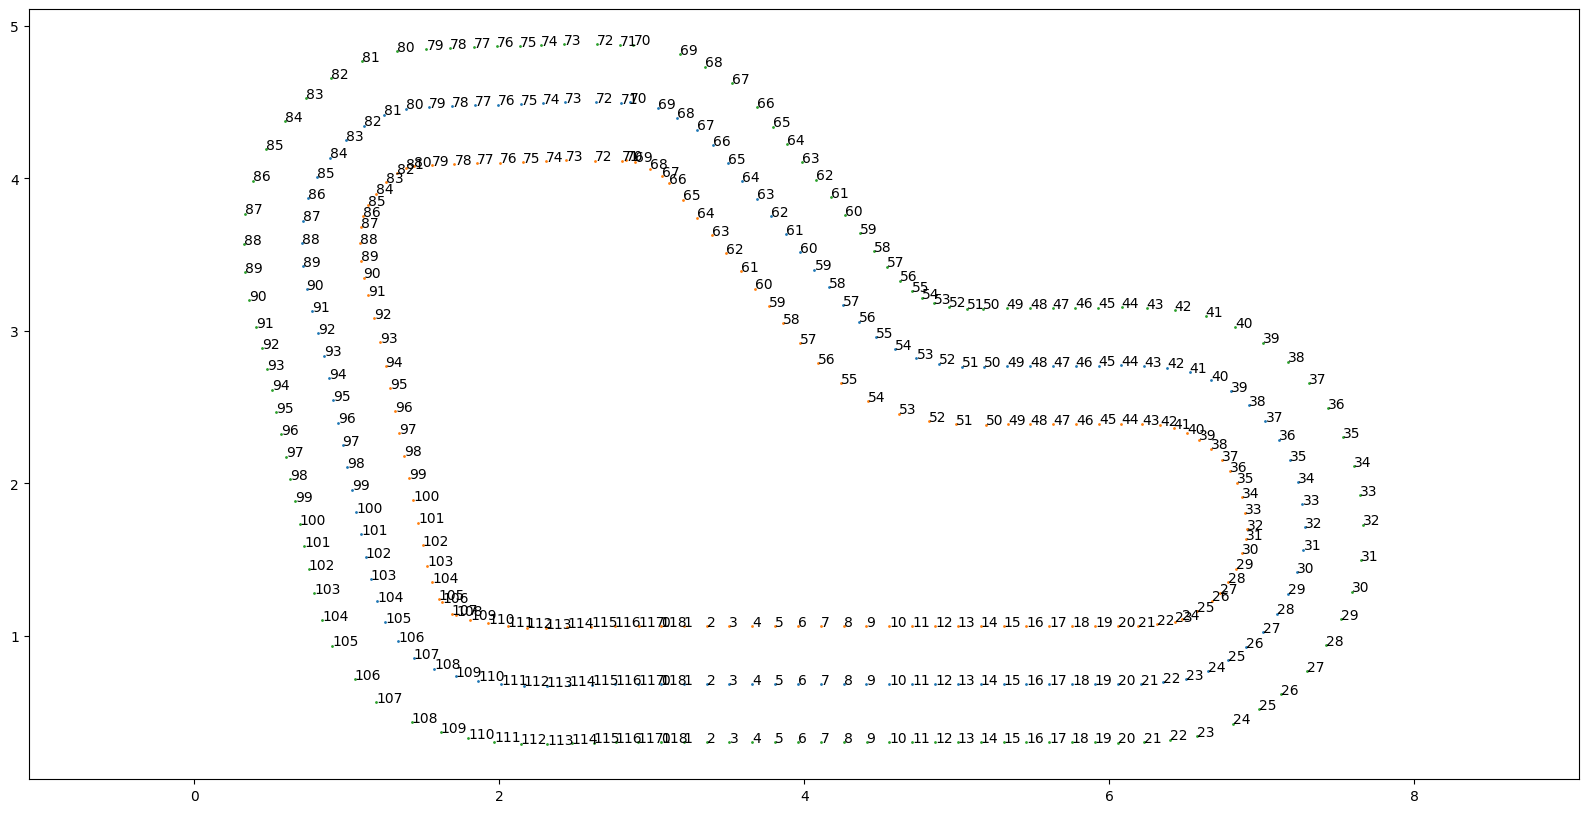

In [129]:
track: Track = tu.load_track("reinvent_base")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. The simplest way to read in training data is using the sim-trace files directly from S3.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md)

In [130]:
# PREFIX='Demo-Reinvent'      # Name of the model, without trailing '/'
# BUCKET='deepracer-local'    # Bucket name is default 'bucket' when training locally
# PROFILE=None                # The credentials profile in .aws - 'minio' for local training
# S3_ENDPOINT_URL=None        # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [131]:
# fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
# log = DeepRacerLog(filehandler=fh)
# log.load_training_trace()

from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog, \
    S3FileHandler, FSFileHandler

fh = FSFileHandler(model_folder='logs/discrete-1-2-1-training_job_dPkJNvOrQ2S2Brq5l8_XGQ_logs/75c480d4-d884-43aa-941b-1beb46fde56c', robomaker_log_path='logs/discrete-1-2-1-training_job_dPkJNvOrQ2S2Brq5l8_XGQ_logs/75c480d4-d884-43aa-941b-1beb46fde56c/logs/training/training-20240327083644-dPkJNvOrQ2S2Brq5l8_XGQ-robomaker.log')
log = DeepRacerLog(filehandler=fh)
log.load_robomaker_logs()


try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Logs not available")

df = log.dataframe()

try:
    EPISODES_PER_ITERATION=int(log.hyperparameters()['num_episodes_between_training']/(df.nunique(axis=0)['worker']))
except Exception:
    print("Multiple workers not detected, assuming 1 worker")
    EPISODES_PER_ITERATION=int(log.hyperparameters()['num_episodes_between_training'])

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5.0'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.99,
 'e_greedy_value': 1.0,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}
-------------
[{'index': 0, 'speed': 1.2, 'steering_angle': -30},
 {'index': 1, 'speed': 1.9, 'steering_angle': -30},
 {'index': 2, 'speed': 1.2, 'steering_angle': -15},
 {'index': 3, 'speed': 2.2, 'steering_angle': -15},
 {'index': 4, 'speed': 3.7, 'steering_angle': 0},
 {'index': 5, 'speed': 2.5, 'steering_angle': 0},
 {'index': 6, 'speed': 1.5, 'steering_angle': 15},
 {'index': 7, 'speed': 2.2, 'steering_angle': 15},
 {'index': 8, 'speed': 1.2, 'steering_angle': 30},
 {'index': 9, 'speed': 1.8, 'steering_angle': 23},
 {'index

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

In [132]:
# Uncomment the line of code below to evaluate a different reward function
# nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Multiple workers not detected, assuming 1 worker
Number of episodes =  244
Number of iterations =  13


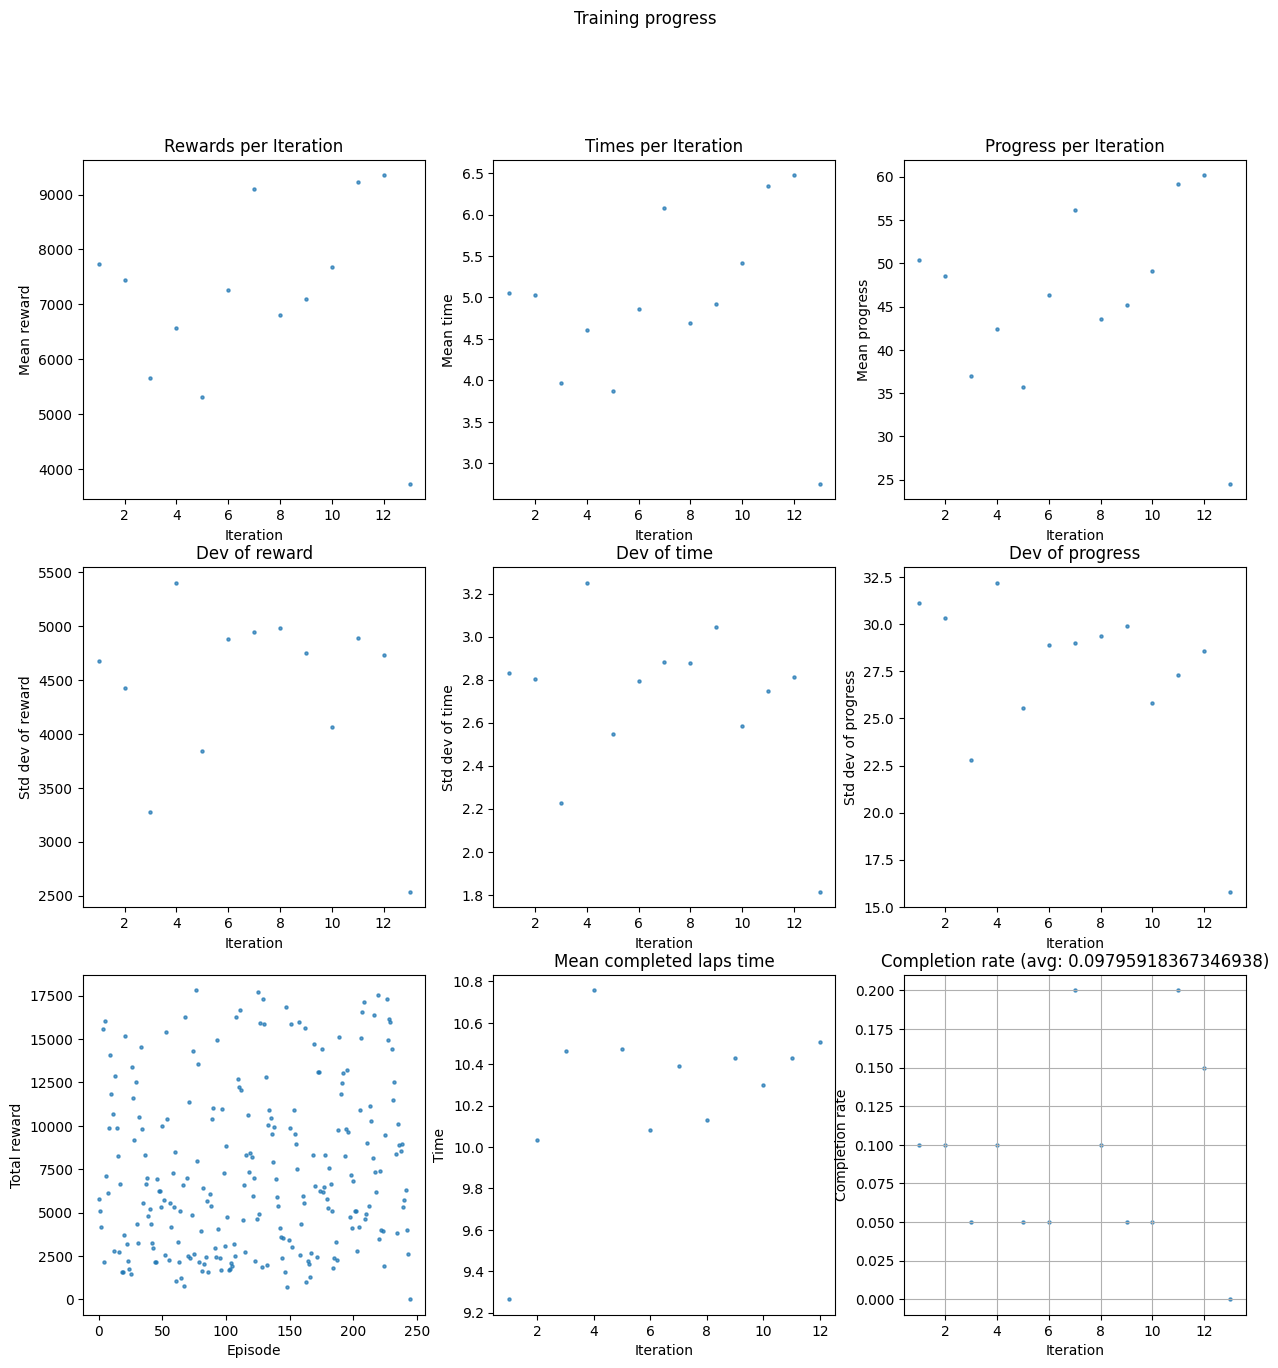

<Figure size 640x480 with 0 Axes>

In [133]:
simulation_agg = au.simulation_agg(df)
try: 
    if df.nunique(axis=0)['worker'] > 1:
        print("Multiple workers have been detected, reloading data with grouping by unique_episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
except:
    print("Multiple workers not detected, assuming 1 worker")
au.analyze_training_progress(simulation_agg, title='Training progress')

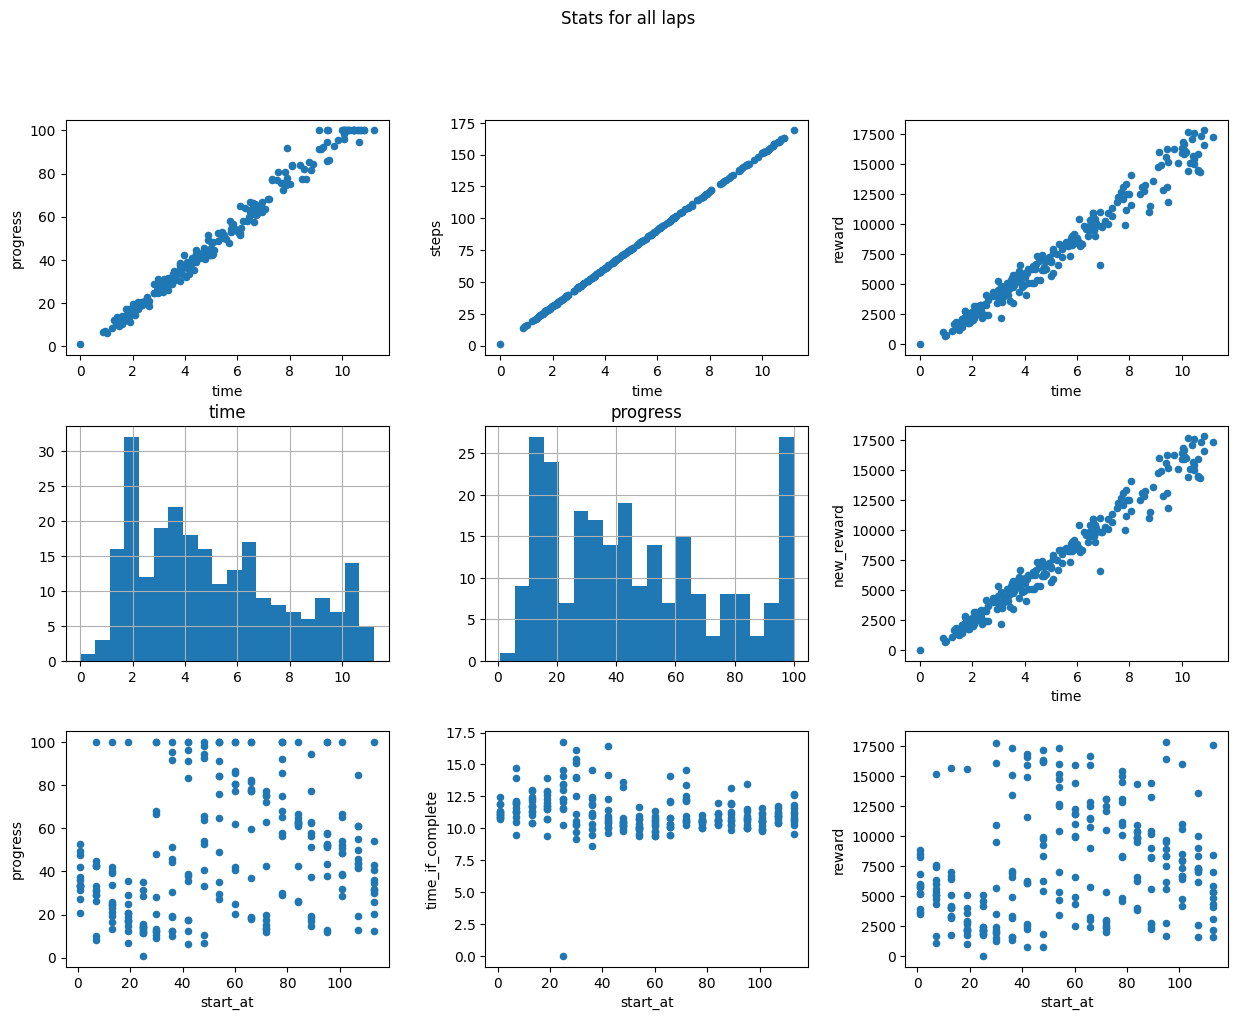

<Figure size 640x480 with 0 Axes>

In [134]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

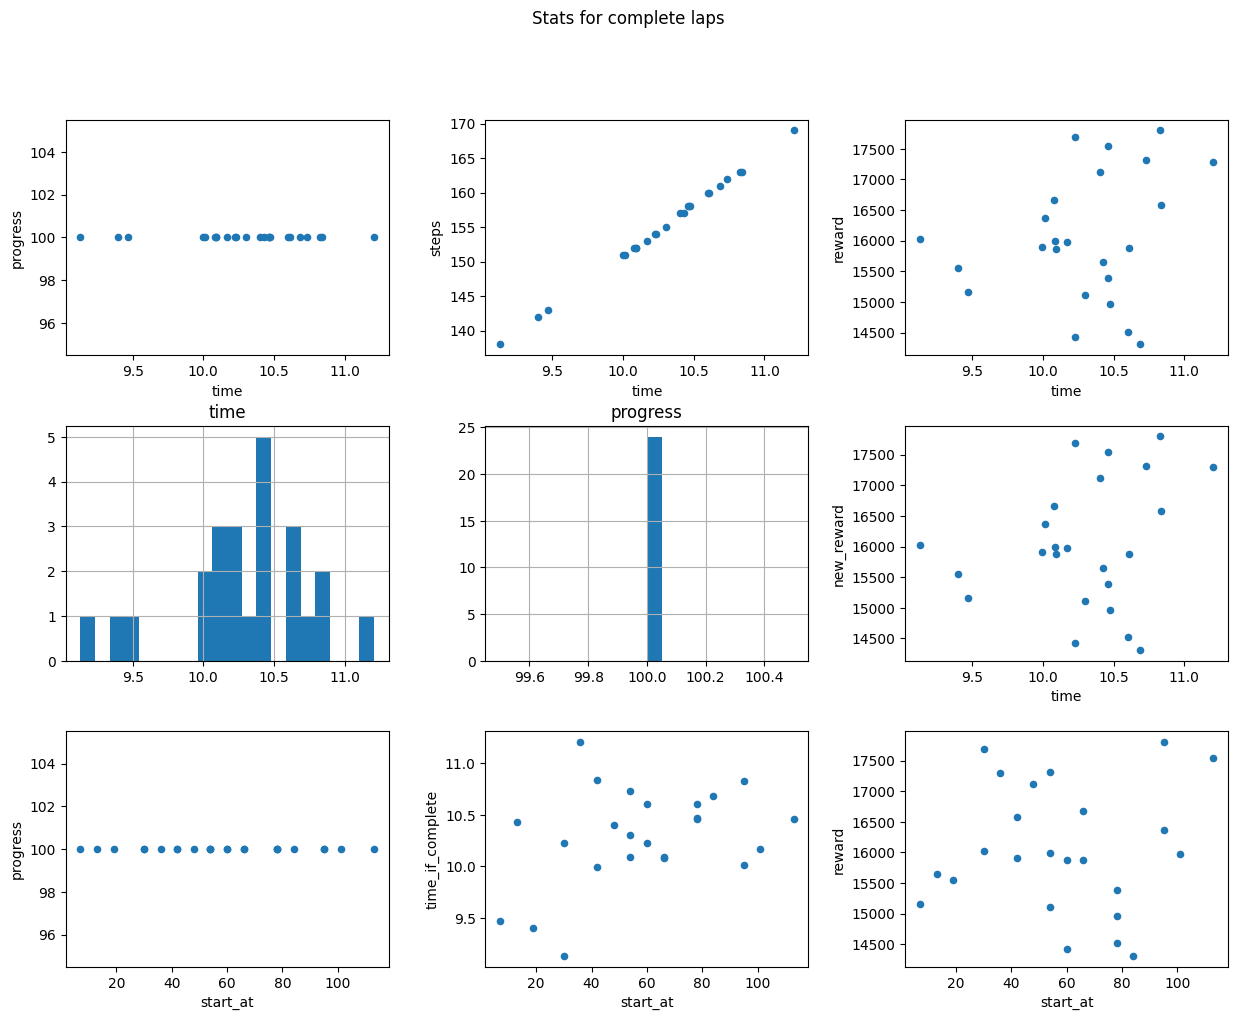

<Figure size 640x480 with 0 Axes>

In [135]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [136]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5567, 'reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
76,4,76,163,95,100.0,10.827,18.438111,17800.0461,1.912270,17800.0461,10.827,17800.0461,2nd,1
125,7,125,154,30,100.0,10.230,17.613689,17691.5257,1.866234,17691.5257,10.230,17691.5257,3rd,1
219,11,219,158,113,100.0,10.464,18.023589,17545.4768,1.877215,17545.4768,10.464,17545.4768,5th,1
129,7,129,162,54,100.0,10.732,17.747132,17311.8348,1.785185,17311.8348,10.732,17311.8348,3rd,1
226,12,226,169,36,100.0,11.207,17.772257,17292.5945,1.688166,17292.5945,11.207,17292.5945,5th,1
208,11,208,157,48,100.0,10.402,17.576409,17113.7557,1.852229,17113.7557,10.402,17113.7557,5th,1
111,6,111,152,66,100.0,10.080,17.035815,16669.7510,1.803289,16669.7510,10.080,16669.7510,3rd,1
207,11,207,163,42,100.0,10.839,17.354326,16574.6050,1.715337,16574.6050,10.839,16574.6050,5th,1
216,11,216,151,95,100.0,10.015,17.409798,16368.5132,1.898675,16368.5132,10.015,16368.5132,5th,1
5,1,5,138,30,100.0,9.130,17.361893,16023.8231,2.087681,16023.8231,9.130,16023.8231,1st,1


In [137]:
# View five most progressed episodes
simulation_agg.nlargest(20, 'progress')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
3,1,3,142,19,100.0,9.398,17.076691,15557.9407,1.965493,15557.9407,9.398,15557.9407,1st,1
5,1,5,138,30,100.0,9.130,17.361893,16023.8231,2.087681,16023.8231,9.130,16023.8231,1st,1
21,2,21,143,7,100.0,9.467,17.241075,15165.4650,2.074126,15165.4650,9.467,15165.4650,1st,1
33,2,33,160,78,100.0,10.602,18.026816,14516.7067,1.851875,14516.7067,10.602,14516.7067,1st,1
53,3,53,158,78,100.0,10.462,18.122228,15392.3318,1.922152,15392.3318,10.462,15392.3318,2nd,1
74,4,74,161,84,100.0,10.685,18.594621,14308.9345,1.849068,14308.9345,10.685,14308.9345,2nd,1
76,4,76,163,95,100.0,10.827,18.438111,17800.0461,1.912270,17800.0461,10.827,17800.0461,2nd,1
93,5,93,158,78,100.0,10.473,18.278967,14970.0405,1.856329,14970.0405,10.473,14970.0405,2nd,1
111,6,111,152,66,100.0,10.080,17.035815,16669.7510,1.803289,16669.7510,10.080,16669.7510,3rd,1
125,7,125,154,30,100.0,10.230,17.613689,17691.5257,1.866234,17691.5257,10.230,17691.5257,3rd,1


In [138]:
# View information for a couple last episodes
simulation_agg.tail()

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
240,13,240,57,1,33.8939,3.753,5.953375,5721.3900,1.966667,5721.3900,11.072789,16880.294094,5th,0
241,13,241,73,7,42.7436,4.814,7.784650,6298.8328,1.983562,6298.8328,11.262505,14736.317952,5th,0
242,13,242,45,13,24.5319,2.971,4.452311,3993.0980,1.828889,3993.0980,12.110762,16277.165650,5th,0
243,13,243,34,19,20.5828,2.209,3.442717,2636.9315,2.052941,2636.9315,10.732262,12811.335192,5th,0
244,13,244,1,25,0.7851,0.000,0.000000,0.0000,2.200000,0.0000,0.000000,0.000000,5th,0


In [139]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==206]

,iteration,episode,steps,x,y,yaw,steering_angle,speed,action,reward,...,on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,delta_time,delta_dist,new_reward
15108,11,206,1,7.0902,2.3322,117.8893,-30.0,1.9,1,0.0000,...,True,0.7874,36,17.71,1341.513,prepare,0.0,0.000,0.000000,0.0000
15109,11,206,2,7.0902,2.3320,117.9352,-15.0,2.2,3,94.1298,...,True,0.7868,36,17.71,1341.617,in_progress,0.0,0.104,0.000200,94.1298
15110,11,206,3,7.0833,2.3505,117.3052,30.0,1.2,8,53.1445,...,True,0.8934,36,17.71,1341.679,in_progress,0.0,0.062,0.019745,53.1445
15111,11,206,4,7.0676,2.3742,117.9144,30.0,1.2,8,50.3903,...,True,1.0536,37,17.71,1341.743,in_progress,0.0,0.064,0.028429,50.3903
15112,11,206,5,7.0357,2.3941,122.4645,30.0,1.2,8,49.3517,...,True,1.2520,37,17.71,1341.81,in_progress,0.0,0.067,0.037598,49.3517
15113,11,206,6,6.9883,2.4183,128.7634,30.0,1.2,8,65.8109,...,True,1.5369,37,17.71,1341.879,in_progress,0.0,0.069,0.053220,65.8109
15114,11,206,7,6.9290,2.4402,136.2328,23.0,1.8,9,75.8080,...,True,1.8607,38,17.71,1341.948,in_progress,0.0,0.069,0.063215,75.8080
15115,11,206,8,6.8573,2.4584,144.5795,15.0,2.2,7,98.2664,...,True,2.2779,38,17.71,1342.021,in_progress,0.0,0.073,0.073974,98.2664
15116,11,206,9,6.7680,2.4727,153.4011,8.0,2.5,12,104.3683,...,True,2.7263,39,17.71,1342.08,in_progress,0.0,0.059,0.090438,104.3683
15117,11,206,10,6.6736,2.4811,161.3148,4.0,3.0,11,141.2556,...,True,3.3239,39,17.71,1342.142,in_progress,0.0,0.062,0.094773,141.2556


# Extract Action Space List from LOG file

In [140]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steering_angle'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.speed.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)[['steering_angle','speed']].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steering_angle[i]*dgr_norm,2), round(AS.speed[i],2))
    asl[j].rel_thr = AS.speed[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steering_angle.min()*dgr_norm,2)
asPlotXmax = round(df.steering_angle.max()*dgr_norm,2)
asPlotYmin = round(df.speed.min(),2)
asPlotYmax = round(df.speed.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.2
1		-30.0		1.9
2		-15.0		1.2
3		-15.0		2.2
4		0.0		3.7
5		0.0		2.5
6		15.0		1.5
7		15.0		2.2
8		30.0		1.2
9		23.0		1.8
10		0.0		1.7
11		4.0		3.0
12		8.0		2.5


## Function definitions

In [141]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steering_angle']*(dgr_norm), episode_data['speed'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steering_angle']*dgr_norm, bins=60)
    ax4.hist(episode_data['speed'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

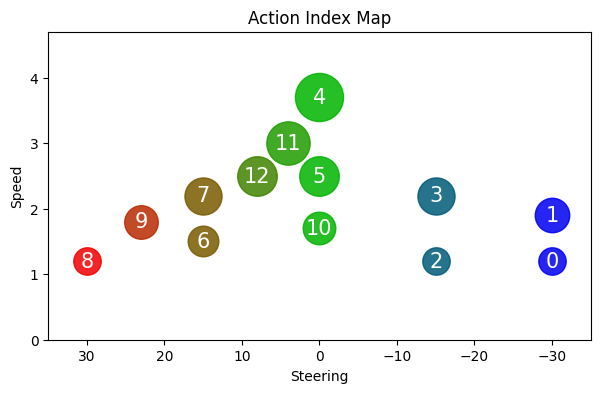

In [142]:
plot_index_map(asl)    

# Analysing data from all episodes

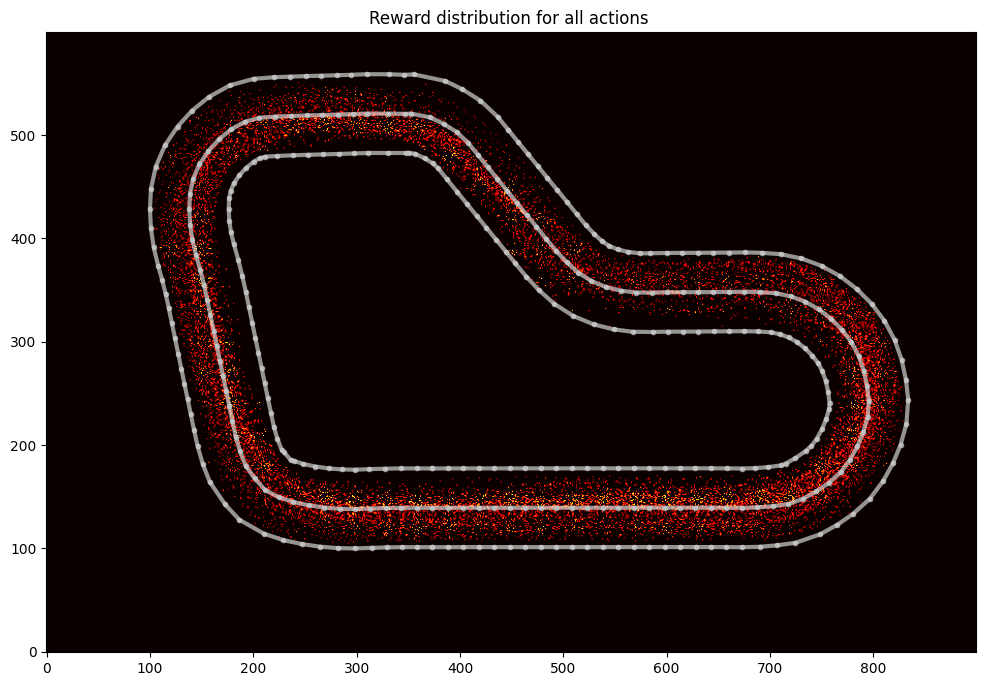

<Figure size 640x480 with 0 Axes>

In [143]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


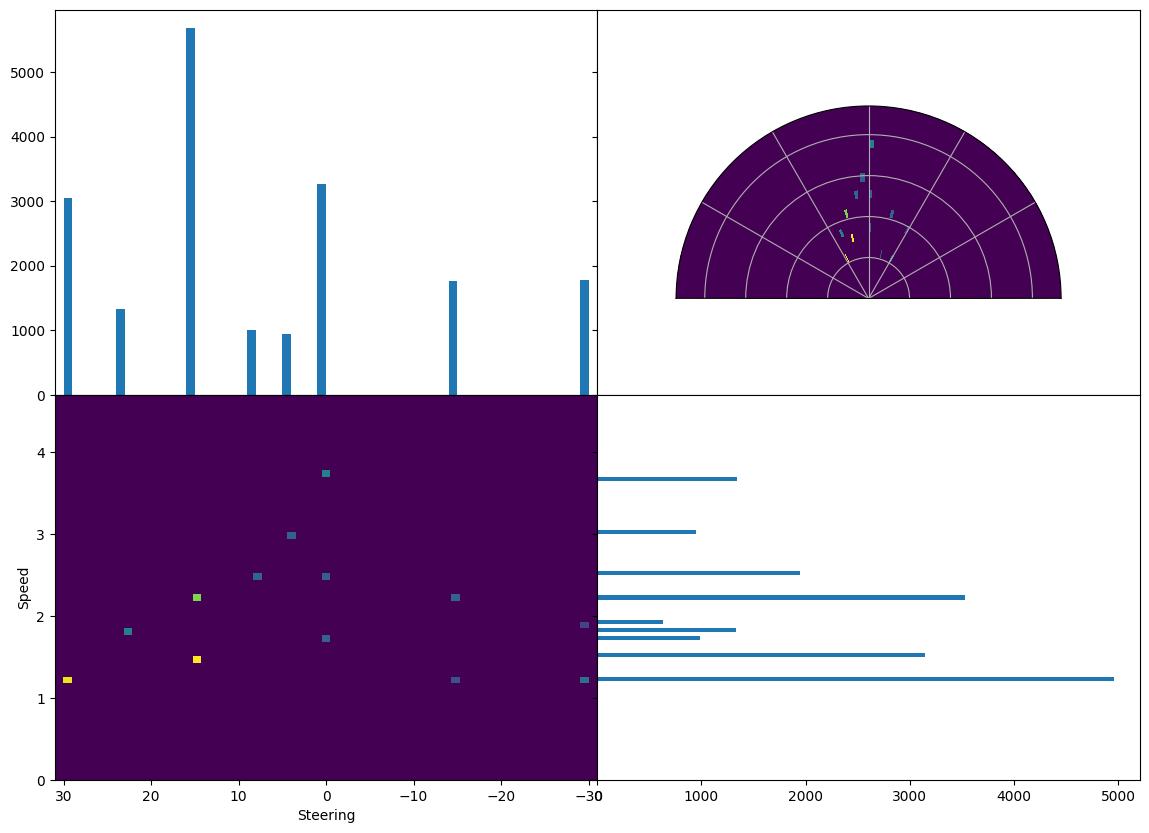

In [144]:
plot_4_hist(df)

Histogram for all episodes:


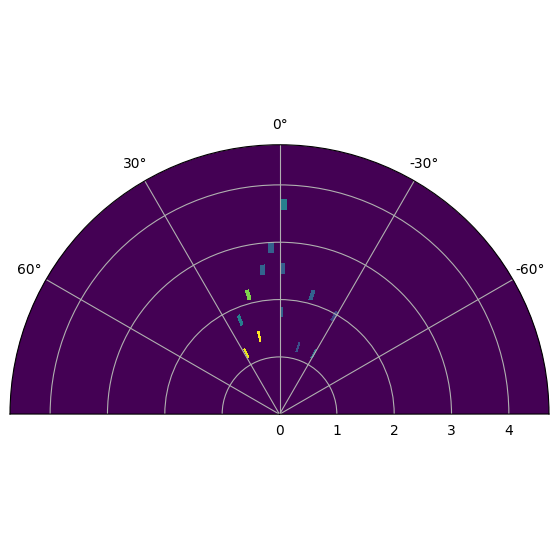

In [145]:
plot_polar_hist(df)



# Analyzing specific iteration





In [146]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()-10     # last iteration

Iteration: 3


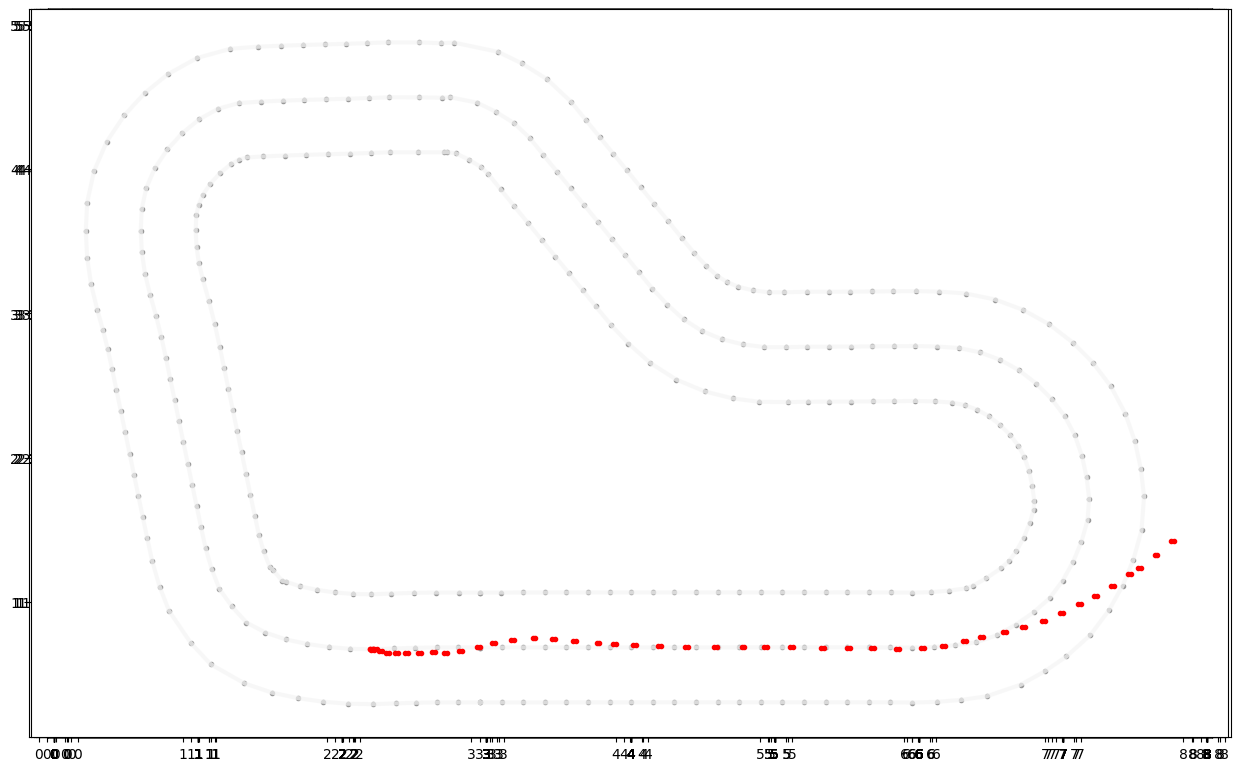

In [147]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 3


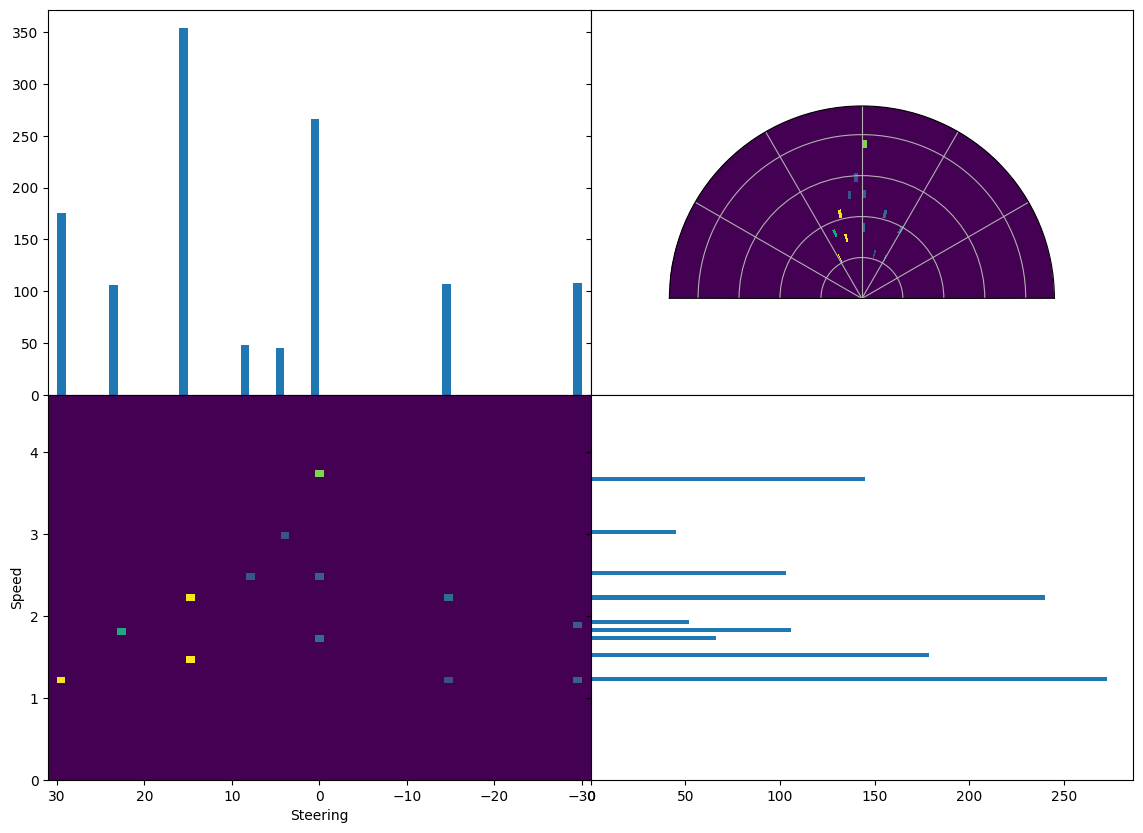

In [148]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 3


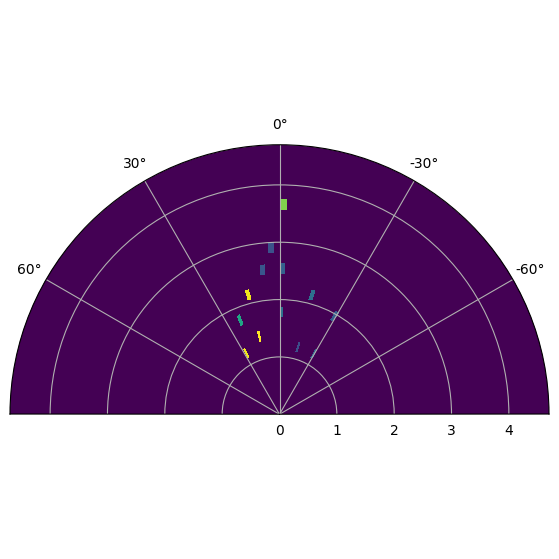

In [149]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [150]:
### choose episode id
EPZ = 21

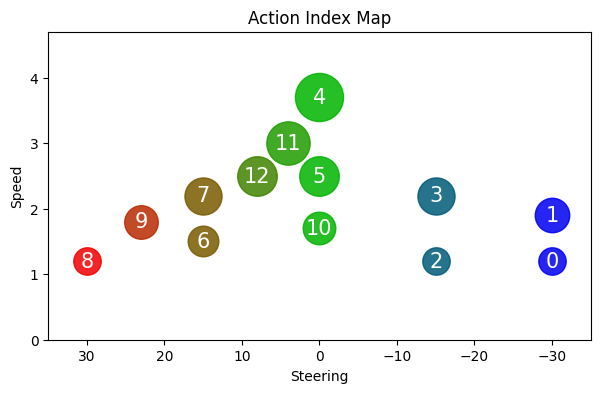

In [151]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


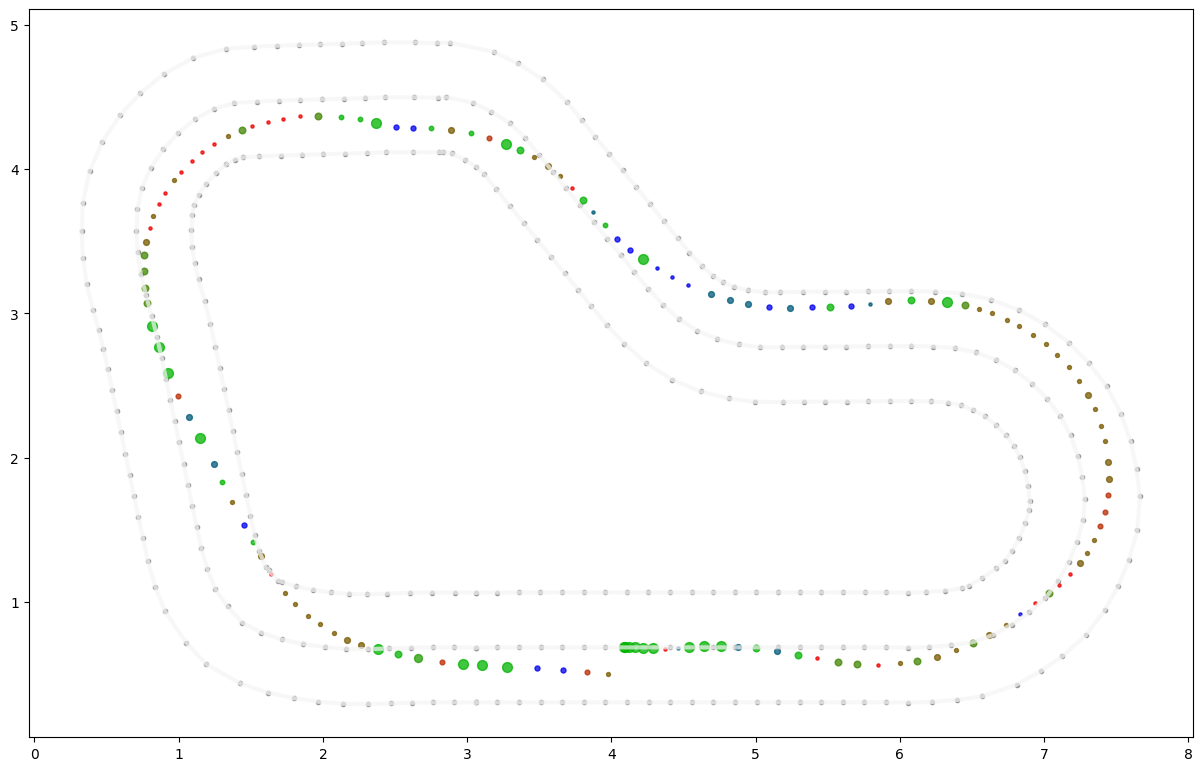

In [152]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 21


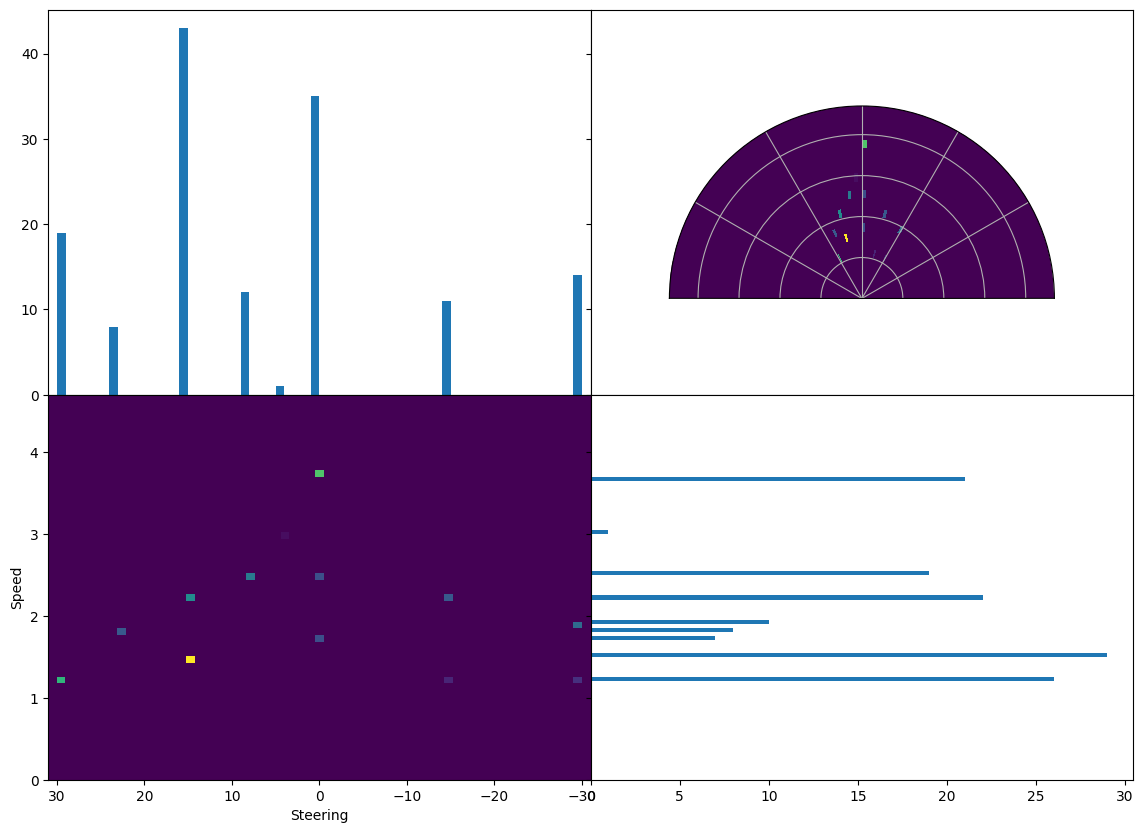

In [153]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 21


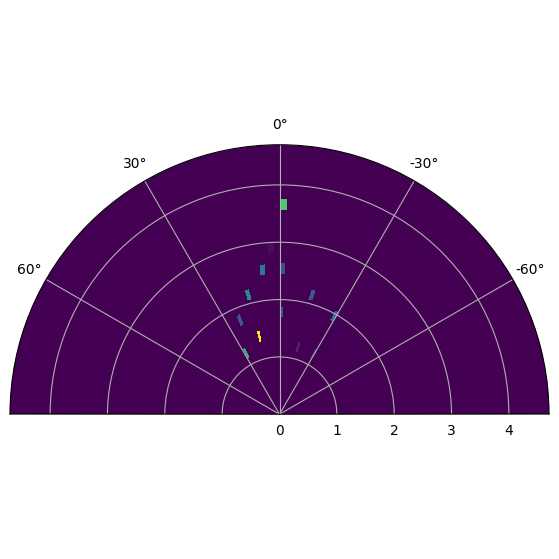

In [154]:
plot_polar_hist(df, E = EPZ)

<Axes: xlabel='closest_waypoint'>

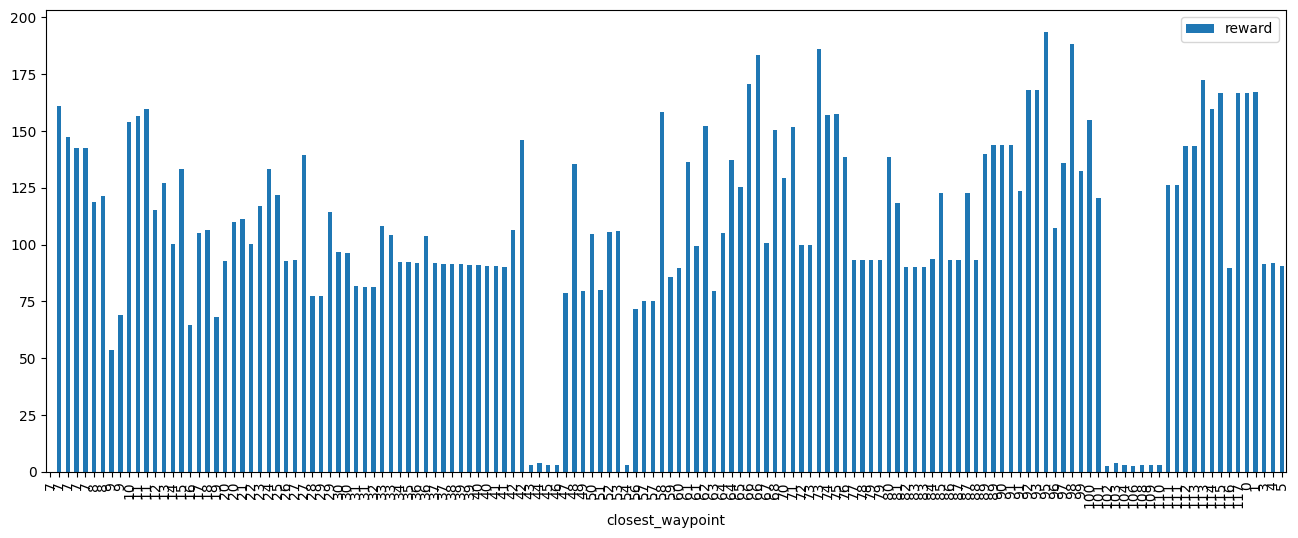

In [155]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(16, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.2


<Figure size 640x480 with 0 Axes>

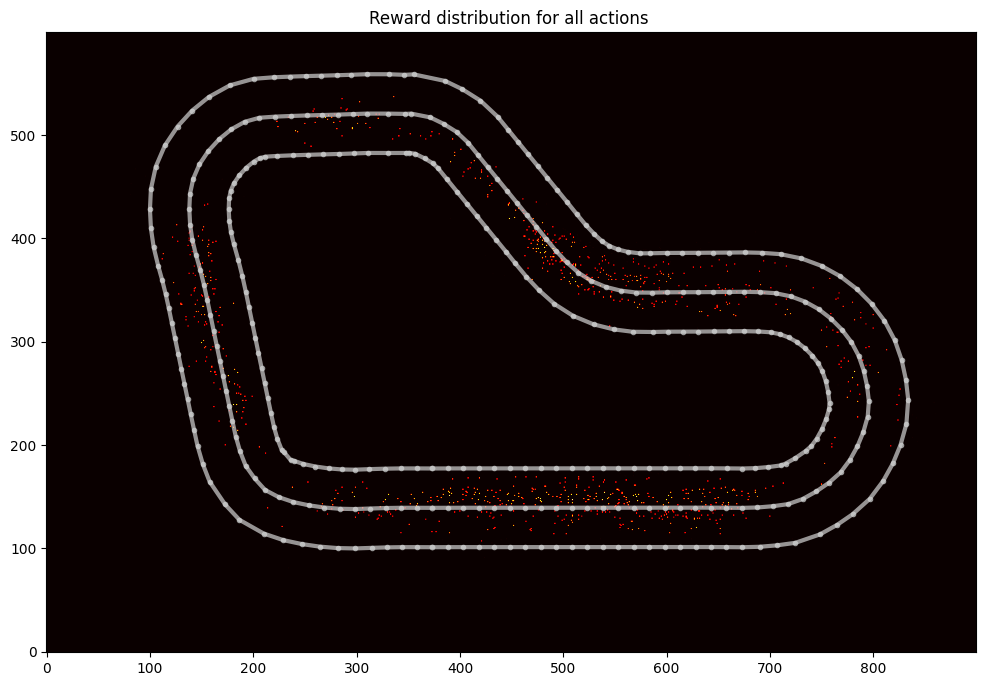

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 1: steering: -30.0, throttle: 1.9


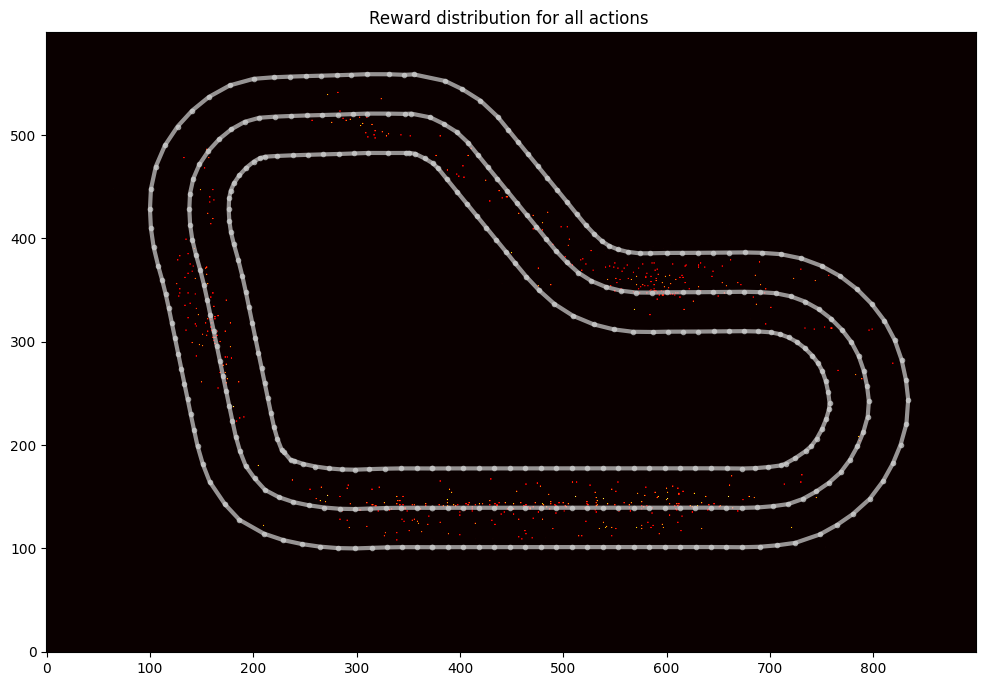

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 2: steering: -15.0, throttle: 1.2


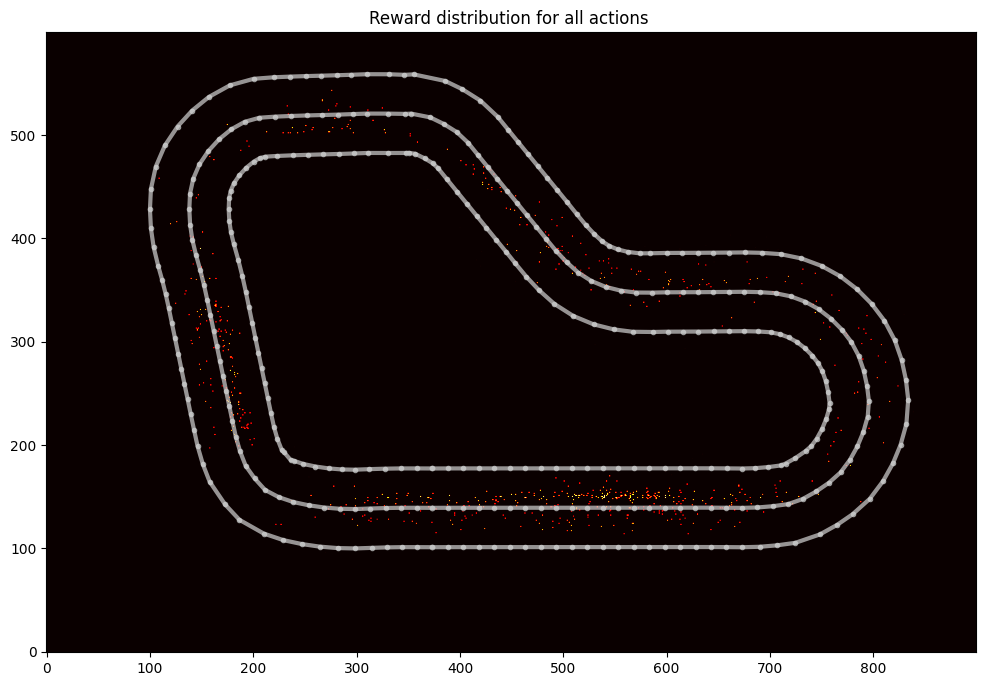

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 3: steering: -15.0, throttle: 2.2


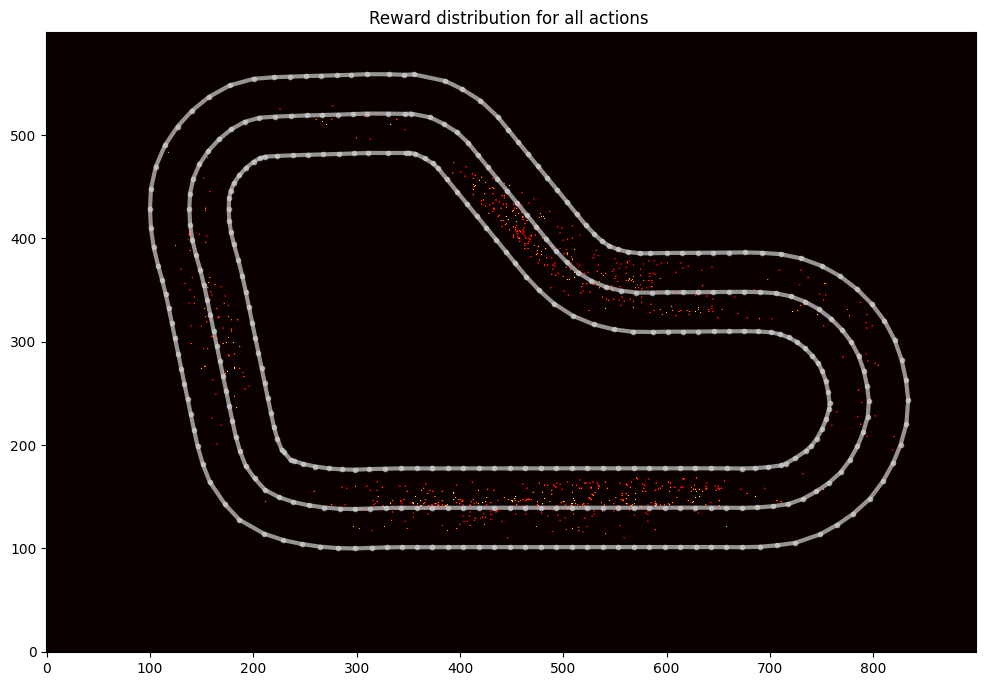

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 4: steering: 0.0, throttle: 3.7


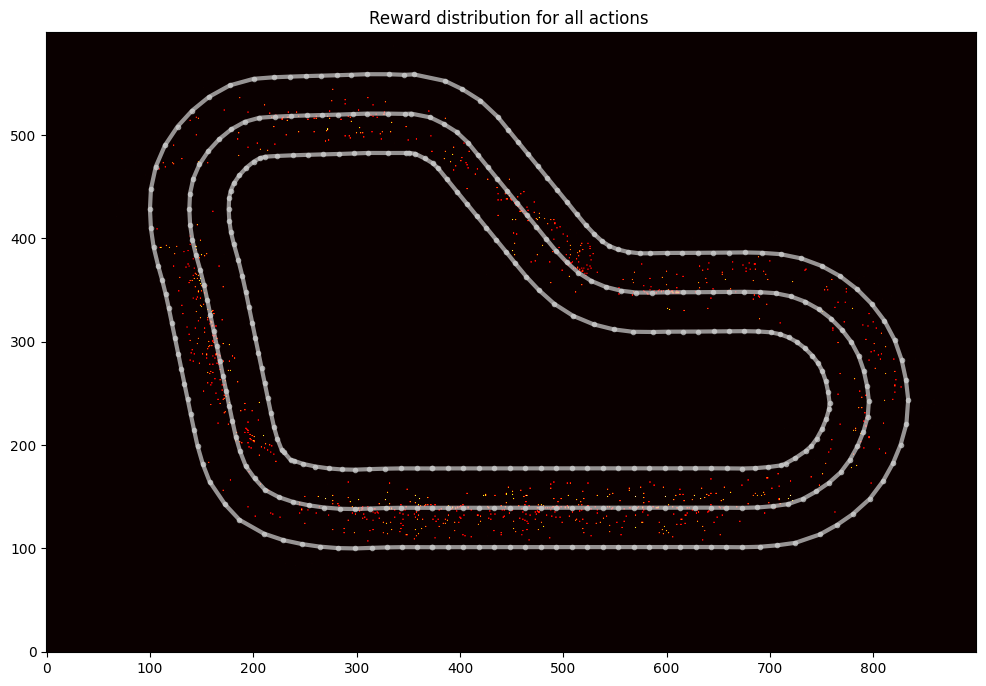

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 5: steering: 0.0, throttle: 2.5


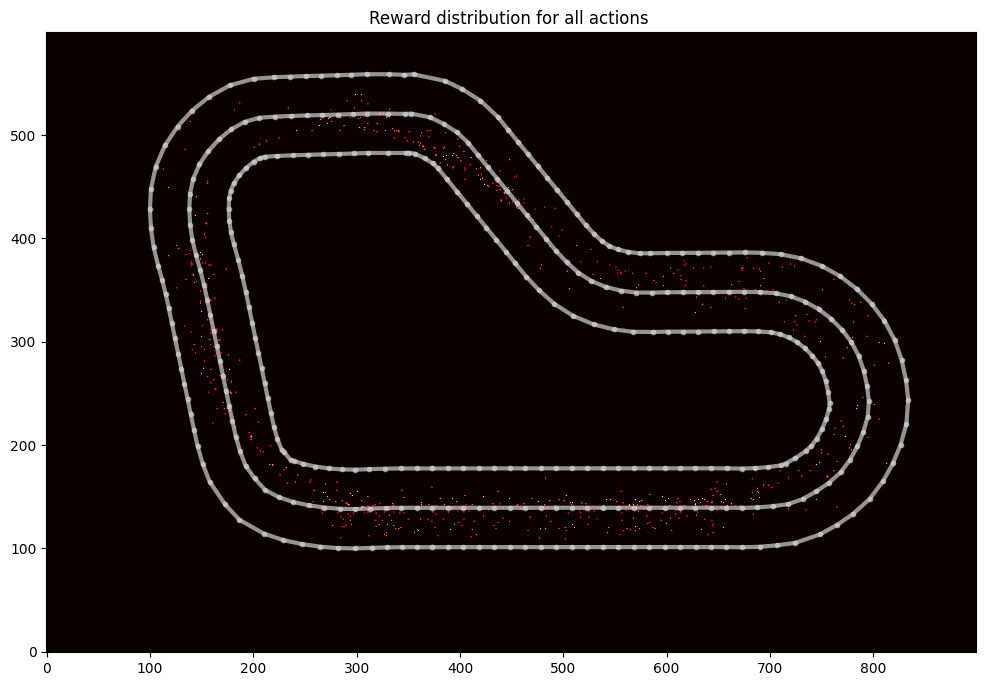

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 6: steering: 15.0, throttle: 1.5


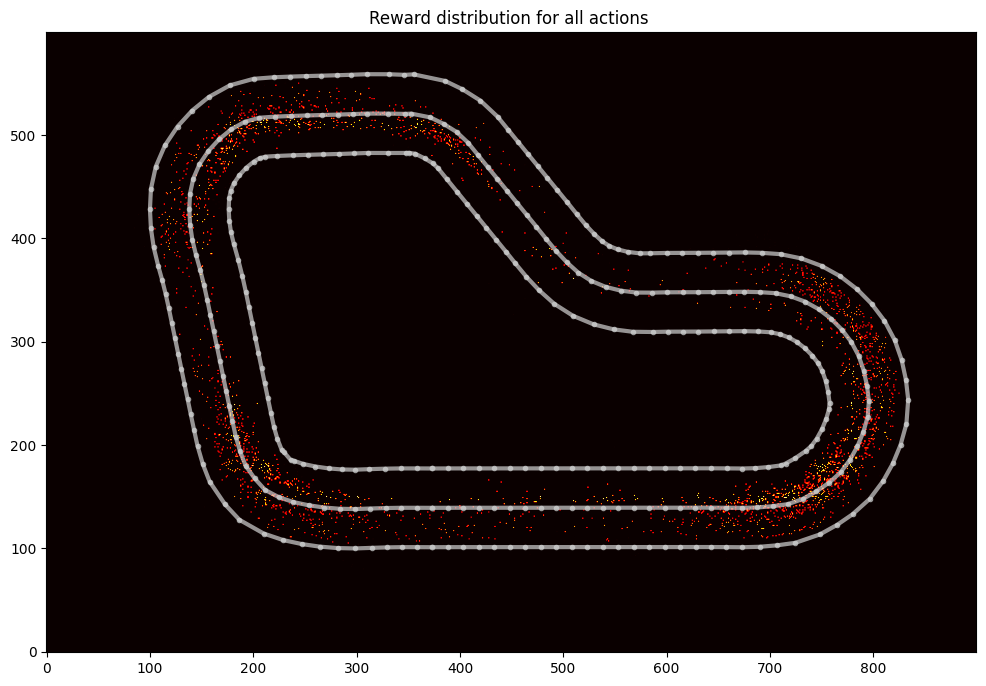

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 7: steering: 15.0, throttle: 2.2


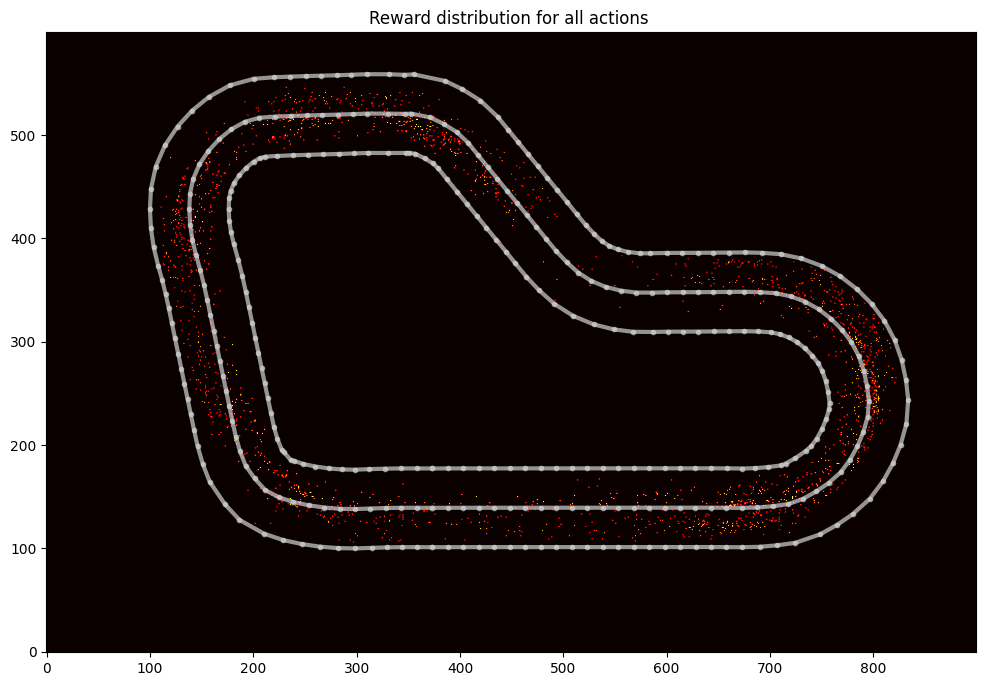

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 8: steering: 30.0, throttle: 1.2


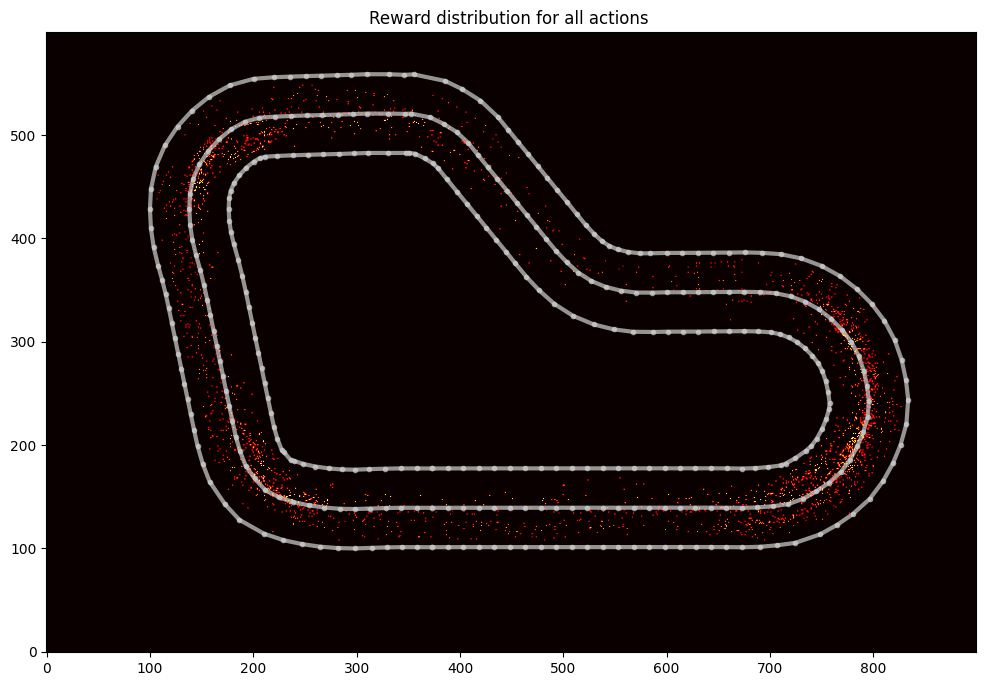

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 9: steering: 23.0, throttle: 1.8


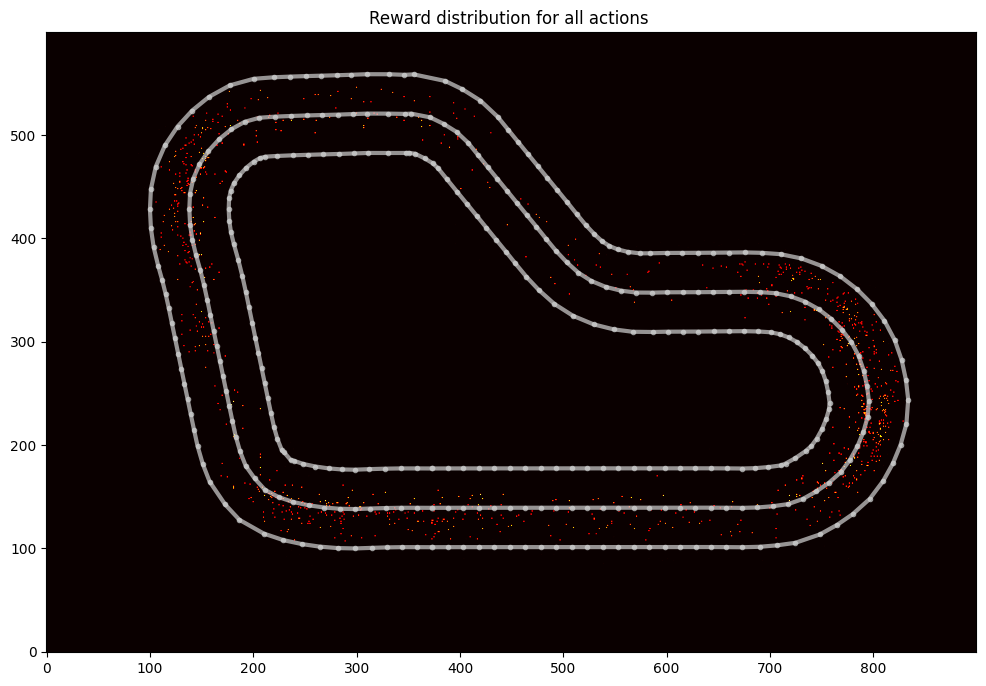

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 1.7


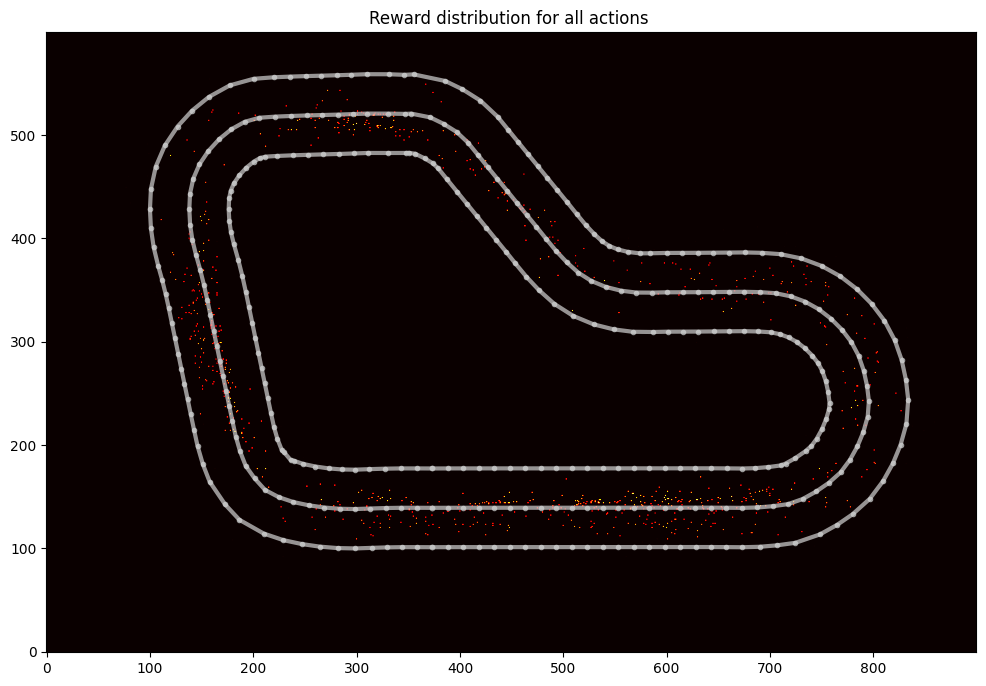

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 11: steering: 4.0, throttle: 3.0


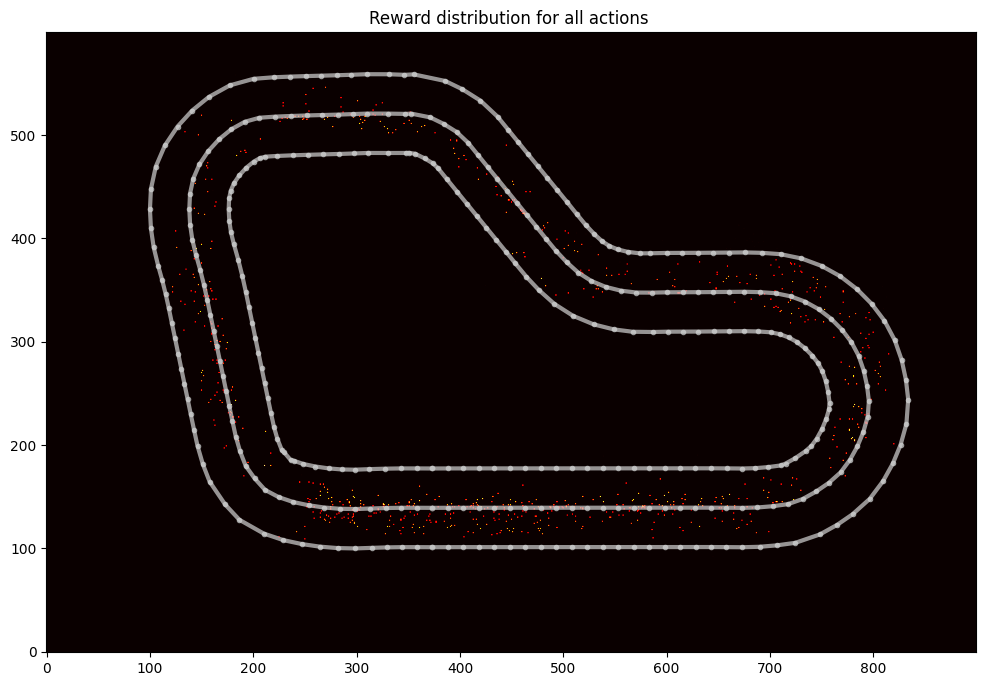

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 12: steering: 8.0, throttle: 2.5


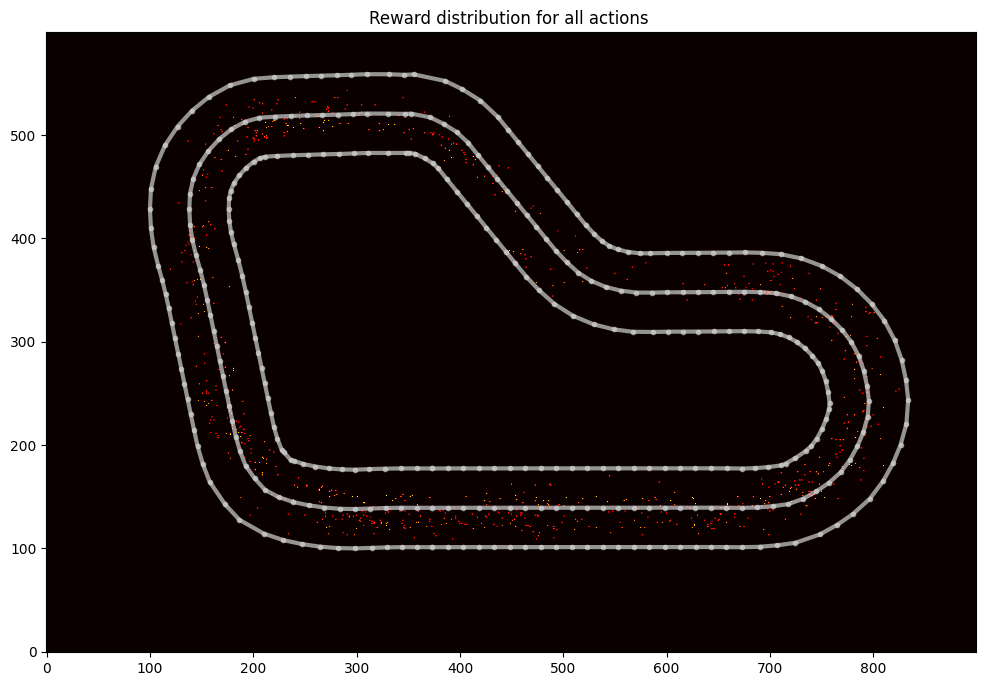

<Figure size 640x480 with 0 Axes>

In [156]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()